In [ ]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn import datasets

from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import smooth_img, new_img_like

In [ ]:
from nilearn.image import threshold_img
from nilearn import surface
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
mni152_template = datasets.load_mni152_template(resolution=1)


In [ ]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids')
deriv_dir = os.path.join(project_dir, 'derivatives')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [ ]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = [
               #'sub-FLT13', 'sub-FLT15', 'sub-FLT17', 'sub-FLT23', 
               'sub-FLT19',
               'sub-FLT27', 
               #'sub-FLT28', 'sub-FLT30'
               ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [ ]:
participants_fpath

In [ ]:
print(participants_df)

In [ ]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [ ]:
sub_list_mand

#### Create design matrixes

In [ ]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

In [ ]:
print(subjects_label)

### Get files

In [ ]:
model_list = ['abs_DSM_PCA_absolute1',  'abs_DSM_PCA_absolute2',  'abs_DSM_PCA_absolute3',
              'rel_DSM_PCA_normalize1', 'rel_DSM_PCA_normalize2', 'rel_DSM_PCA_normalize3', 
              'FFR', 'Tone', 'Talker']

model_label = 'Tone'

In [ ]:
contrast_label = 'sound'
fwhm = 0.00
searchrad = 9
space_label = 'MNI152NLin2009cAsym'
search_label = 'rsa-searchlight_fwhm-%.02f_searchvox-%d_run-all_LSS'%(fwhm, searchrad)
l1_dir = os.path.join(bidsroot, 'derivatives', 
                      'nilearn', 'level-1_fwhm-%.02f'%fwhm)

In [ ]:
for subtest in subjects_label:
    print(l1_dir+'/%s_space-%s/%s/'%(subtest, space_label, search_label)+'%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(subtest, fwhm, searchrad, model_label))

In [ ]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)))[0] for sub_id in subjects_label]

In [ ]:
l1_fnames_groupdiff

In [ ]:
l1_fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)))[0] for sub_id in sub_list_mand]
l1_fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)))[0] for sub_id in sub_list_nman]

### Mandarin-speaking participants group RSA

In [33]:
from nilearn.image import threshold_img
threshold = 0.1
cthresh = 10

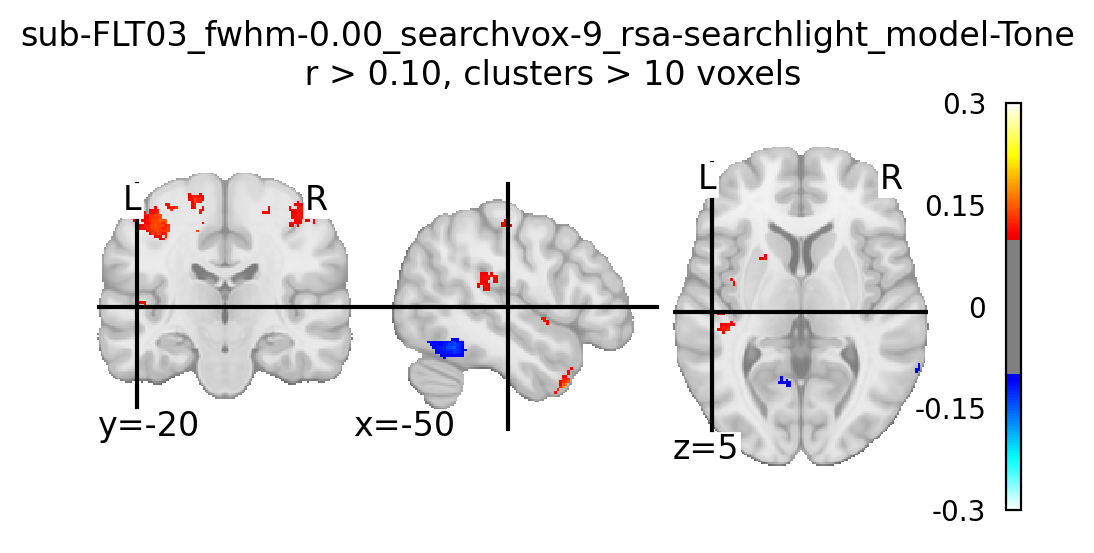

In [38]:

for r_map in [l1_fnames_mand[0]]:
    fbase = os.path.basename(r_map).split('.nii.gz')[0]


    thresholded_map = threshold_img(
                                    r_map,
                                    threshold=threshold,
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                )
    title='%s\n r > %.02f, clusters > %d voxels'%(fbase, threshold, cthresh)

    fig, axes = plt.subplots(1, 1, figsize=(6,3), dpi=200)
    fig.suptitle(title)

    plotting.plot_stat_map(
        thresholded_map, 
        bg_img=mni152_template,
        black_bg=False,
        cut_coords=[-50,-20,5], 
        threshold=threshold,
        vmax=0.30,
        figure=fig,
        axes=axes
        )
    fig.show()

In [ ]:
for r_map in l1_fnames_nman:
    fbase = os.path.basename(r_map).split('.nii.gz')[0]


    thresholded_map = threshold_img(
                                    r_map,
                                    threshold=threshold,
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                )
    title='%s\n r > %.02f, clusters > %d voxels'%(fbase, threshold, cthresh)

    fig, axes = plt.subplots(1, 1, figsize=(6,3), dpi=200)
    fig.suptitle(title)

    plotting.plot_stat_map(
        thresholded_map, 
        cut_coords=[-50,-20,5], 
        threshold=threshold,
        #vmax=0.50,
        figure=fig,
        axes=axes
        )
    fig.show()

In [15]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  cut_coords=[-50,-20,5], 
                  #vmax=0.50,
                  symmetric_cmap=True)

NameError: name 'thresholded_map' is not defined

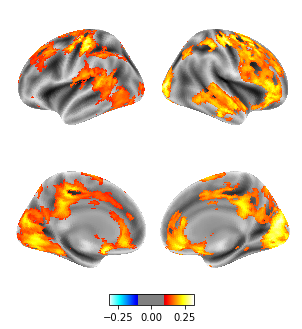

In [204]:
plotting.plot_img_on_surf(thresholded_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          #title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh)
                         )
plotting.show()

### plot participant x searchrad plot

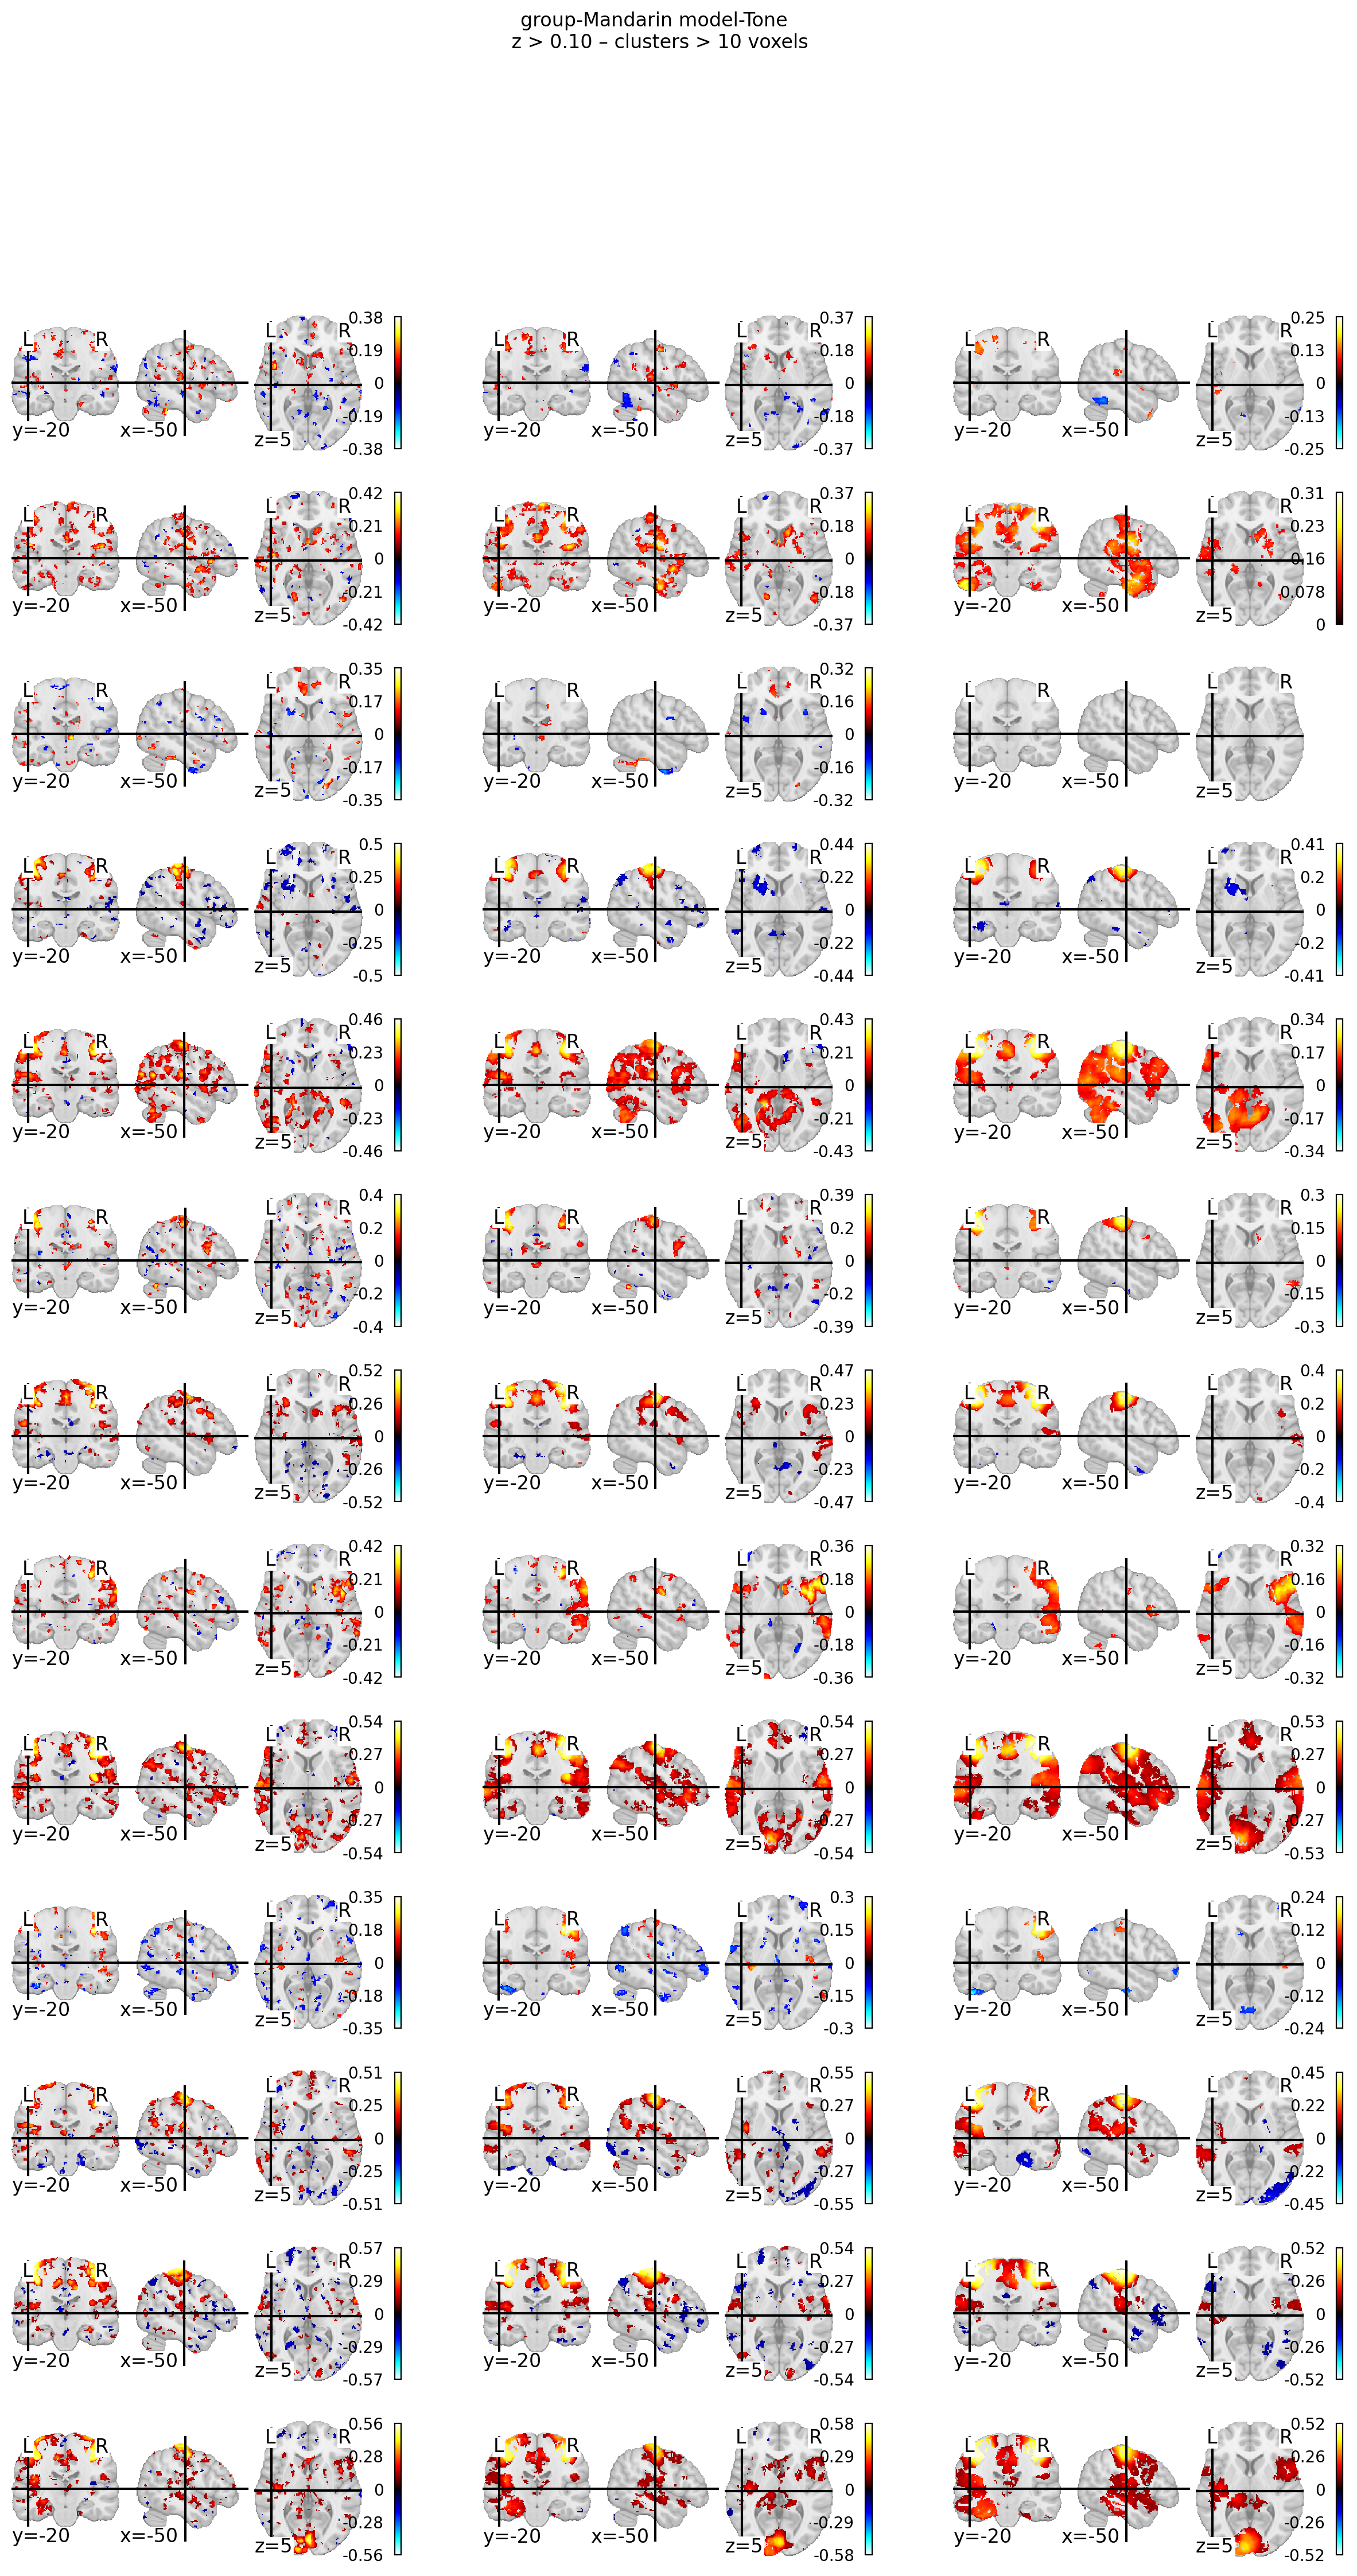

In [51]:
n_subs = len(sub_list_mand)
group_label = 'Mandarin'
title='group-%s model-%s \n z > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
#fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
#subfigs = fig.subfigures(nrows=3, ncols=1)
fig, axes = plt.subplots(n_subs, 3, figsize=(15,2*n_subs), dpi=200)
fig.suptitle(title)

for sx, sub_id in enumerate(sub_list_mand):
    for rx, searchrad in enumerate([3, 5, 9]):

        img_fname = '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)
        search_label = 'rsa-searchlight_fwhm-%.02f_searchvox-%d_run-all_LSS'%(fwhm, searchrad)
        img_fpath = os.path.join(l1_dir,
                                 '%s_space-%s/%s/'%(sub_id, space_label, search_label),
                                 img_fname)

        #fig_fpath = os.path.join('level-2_out', 
        #                         'group-{}_rsa-searchlight_model-{}_map-zstat_slice.png'.format(group_label, model_label))
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )

        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               cut_coords=[-50,-20,5],
                               #colorbar=False,
                               #annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[sx, rx])
        

        #fig.savefig(fig_fpath)

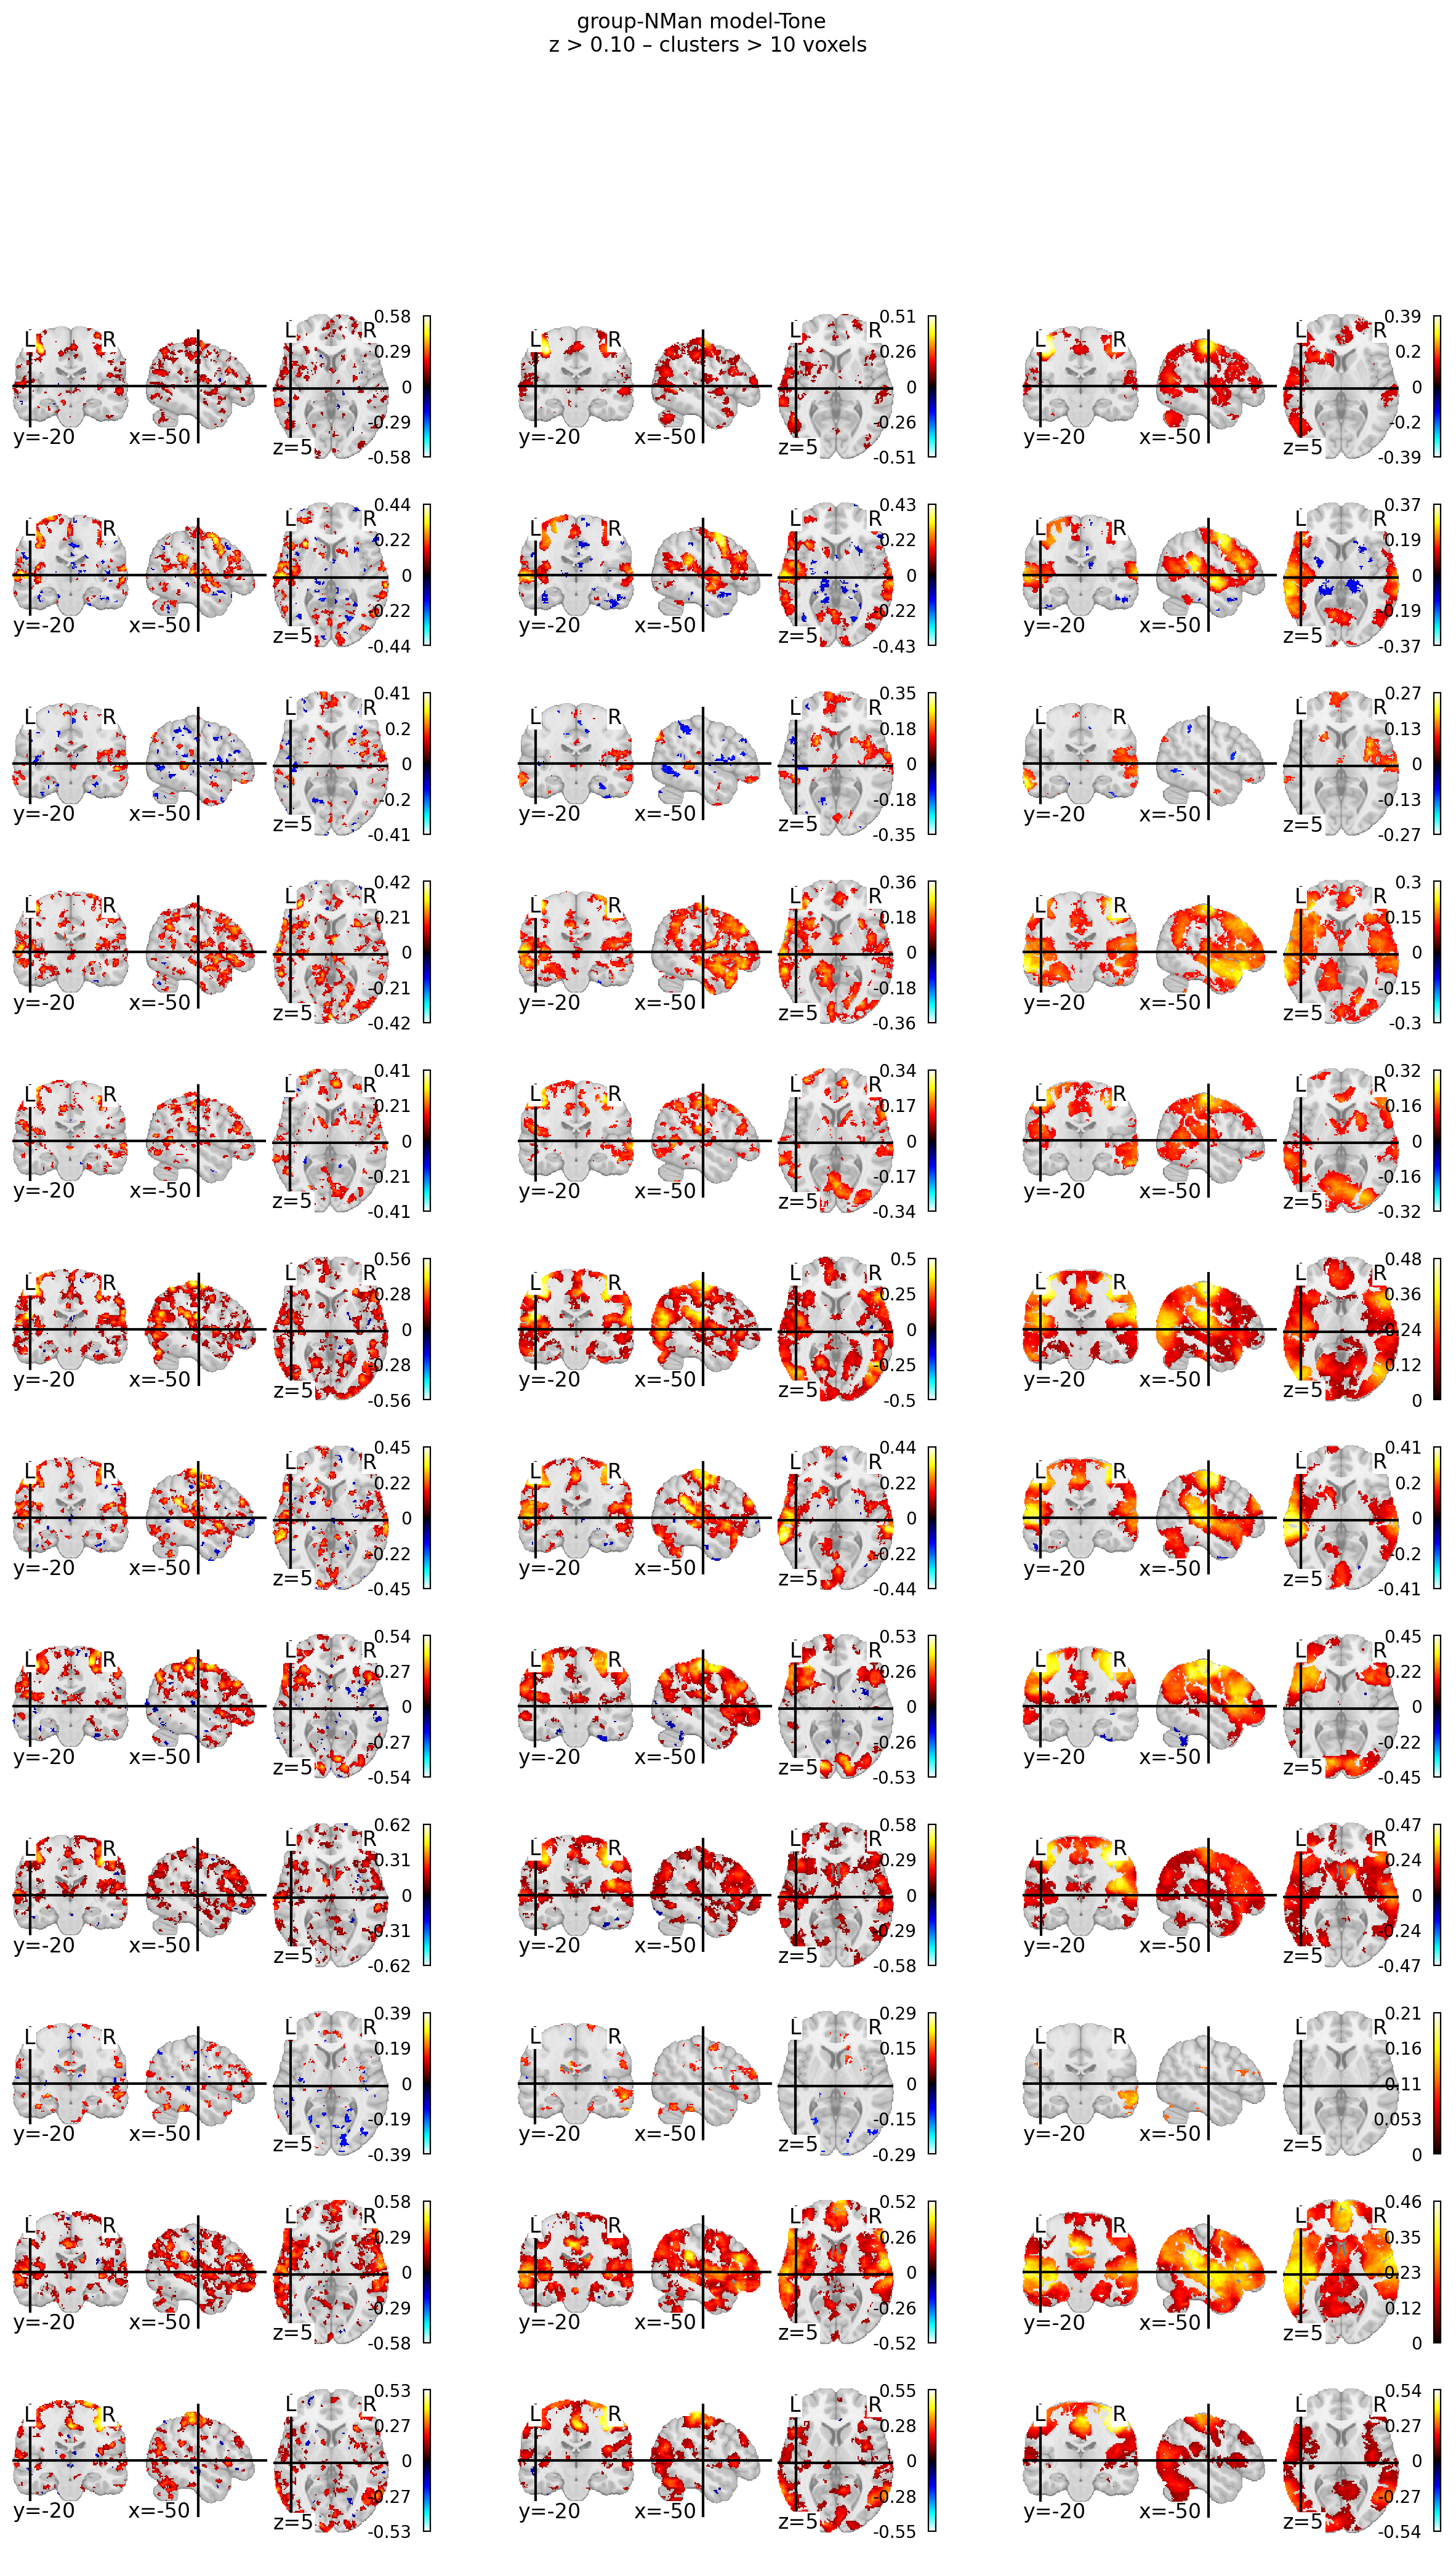

In [52]:
n_subs = len(sub_list_nman)
group_label = 'NMan'
title='group-%s model-%s \n z > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
#fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
#subfigs = fig.subfigures(nrows=3, ncols=1)
fig, axes = plt.subplots(n_subs, 3, figsize=(15,2*n_subs), dpi=200)
fig.suptitle(title)

for sx, sub_id in enumerate(sub_list_nman):
    for rx, searchrad in enumerate([3, 5, 9]):

        img_fname = '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)
        search_label = 'rsa-searchlight_fwhm-%.02f_searchvox-%d_run-all_LSS'%(fwhm, searchrad)
        img_fpath = os.path.join(l1_dir,
                                 '%s_space-%s/%s/'%(sub_id, space_label, search_label),
                                 img_fname)

        #fig_fpath = os.path.join('level-2_out', 
        #                         'group-{}_rsa-searchlight_model-{}_map-zstat_slice.png'.format(group_label, model_label))
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )

        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               cut_coords=[-50,-20,5],
                               #colorbar=False,
                               #annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[sx, rx])
        

        #fig.savefig(fig_fpath)

## loop over all images and save

In [ ]:
for group_label in ['Mand', 'NMan', 'diff-Mand-gt-NMan']: #
    for model_label in model_list:
        img_fname = 'group-{}_rsa-searchlight_model-{}_map-zstat.nii.gz'.format(group_label, model_label)
        img_fpath = os.path.join(l2_dir, img_fname)

        fig_fpath = os.path.join('level-2_out', 
                                 'group-{}_rsa-searchlight_model-{}_map-zstat.png'.format(group_label, 
                                                                                          model_label))
        title='group-%s model-%s\nz > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
        threshold = 2.58
        cthresh = 10
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )
        #fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,4), dpi=500)
        fig, ax = plotting.plot_img_on_surf(thresholded_map,
                                  surf_mesh='fsaverage',
                                  views=['lateral', 'medial'],
                                  hemispheres=['left', 'right'],
                                  inflate=True,
                                  threshold=threshold,
                                  colorbar=True,
                                  title=title,
                                  #kwargs={'figure':fig, 'axes':ax}
                                 )
        fig.savefig(fig_fpath)
        print('file saved to ', fig_fpath)

In [ ]:
threshold = 2.58
cthresh = 10
    
for group_label in ['Mand', 'NMan', 'diff-Mand-gt-NMan']: # 'Mand', 'NMan', 'diff-Mand-gt-NMan'
    for model_label in model_list:
        title='group-%s model-%s \n z > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
        
        #fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
        #subfigs = fig.subfigures(nrows=3, ncols=1)
        fig, axes = plt.subplots(3, 1, figsize=(6,3), dpi=500)
        fig.suptitle(title)
        
        img_fname = 'group-{}_rsa-searchlight_model-{}_map-zstat.nii.gz'.format(group_label, model_label)
        img_fpath = os.path.join(l2_dir, img_fname)

        fig_fpath = os.path.join('level-2_out', 
                                 'group-{}_rsa-searchlight_model-{}_map-zstat_slice.png'.format(group_label, 
                                                                                          model_label))
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )

        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='x',
                               cut_coords=[-60, -45, -30, -15, 0, 15, 30, 45, 60],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[0])
        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='y',
                               cut_coords=[-100, -80, -60, -40, -20, 0, 20, 40, 60],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[1])
        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='z',
                               cut_coords=[-50, -35, -20, -5, 10, 25, 40, 55, 70],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               #figure=fig, 
                               axes=axes[2])
        
        fig.savefig(fig_fpath)
        print('file saved to ', fig_fpath)